In [112]:
import pandas as pd
import numpy as np
M=100000
data = pd.read_csv('train_2011_2012_2013.csv',delimiter=';',usecols=['DATE','ASS_ASSIGNMENT','CSPL_RECEIVED_CALLS'], nrows=M)
#data = pd.read_csv('train_2011_2012_2013.csv',delimiter=';',usecols=['DATE','ASS_ASSIGNMENT','CSPL_RECEIVED_CALLS'])

In [113]:
d = pd.DataFrame(data.groupby(['DATE', 'ASS_ASSIGNMENT'])['CSPL_RECEIVED_CALLS'].sum())
d.reset_index(level=0, inplace=True)
d.reset_index(level=0, inplace=True)
data = d

In [114]:
import time
data['time'] = data['DATE'].apply(lambda x: time.strptime(x, '%Y-%m-%d %H:%M:%S.000'))
data['day_week'] = data['time'].apply(lambda x: time.strftime("%w", x))
data['month'] = data['time'].apply(lambda x: time.strftime("%m", x))

In [115]:
data['ASS_ASSIGNMENT'].value_counts()

Nuit                              1543
Médical                           1543
Téléphonie                        1543
Tech. Inter                       1542
RENAULT                           1542
Domicile                          1542
Services                          1541
Gestion                           1540
Japon                             1540
SAP                               1528
Gestion - Accueil Telephonique    1515
Gestion Renault                   1476
Crises                            1450
Tech. Axa                         1389
Regulation Medicale               1325
Gestion Assurances                1202
Gestion Amex                      1192
Tech. Total                        961
Gestion Clients                    736
Manager                            604
Gestion DZ                         507
Gestion Relation Clienteles        450
RTC                                361
Mécanicien                         340
Prestataires                       112
CMS                      

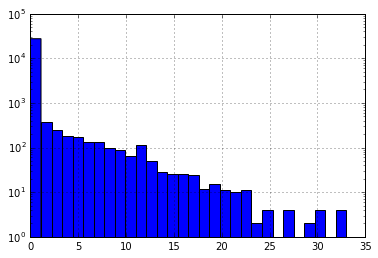

In [116]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.yscale('log')
data['CSPL_RECEIVED_CALLS'].hist(bins=30)

In [117]:
### New features: dummies for the day of the week, ASS_ASSIGNMENT, months

data = pd.concat((data, pd.get_dummies(data['day_week'])),axis=1)
data = pd.concat((data, pd.get_dummies(data['ASS_ASSIGNMENT'])),axis=1)
data = pd.concat((data, pd.get_dummies(data['month'])),axis=1)

In [118]:
data['H-M'] = data['time'].apply(lambda t: time.strftime("%H-%M", t))

In [119]:
### New feature: hours since the start of the day

data['hours'] = data['time'].apply(lambda x: float(time.strftime("%H", x))+np.sign(float(time.strftime("%M", x)))*0.5)

In [120]:
data['hours'].value_counts()

0.0    2290
3.5    2274
5.5    2273
1.0    2273
5.0    2269
4.5    2267
0.5    2267
4.0    2266
3.0    2258
2.5    2254
2.0    2248
1.5    2247
6.0    1337
7.0     621
6.5      66
Name: hours, dtype: int64

In [121]:
### date scince epoch
data['time_absolut'] = data['time'].apply(time.mktime)

In [122]:
time.gmtime(data['time_absolut'].max())

time.struct_time(tm_year=2011, tm_mon=4, tm_mday=30, tm_hour=4, tm_min=0, tm_sec=0, tm_wday=5, tm_yday=120, tm_isdst=0)

In [123]:
time.gmtime(data['time_absolut'].min())

time.struct_time(tm_year=2010, tm_mon=12, tm_mday=31, tm_hour=23, tm_min=0, tm_sec=0, tm_wday=4, tm_yday=365, tm_isdst=0)

In [124]:
### New feature: average number of calls during h hours before the time for the specific category

def get_window1(x, h):
    interval = h*3600
    tmp = data[data['ASS_ASSIGNMENT'] == x['ASS_ASSIGNMENT']]
    tmp = tmp[tmp['time_absolut'] >= x['time_absolut']-interval] 
    tmp = tmp[tmp['time_absolut'] < x['time_absolut']]
    return tmp['CSPL_RECEIVED_CALLS'].mean()

data['mean_calls_24h_past_time'] = data[['time_absolut','ASS_ASSIGNMENT','CSPL_RECEIVED_CALLS']].apply(lambda p: get_window1(p, 24),axis=1)

In [125]:
data['mean_calls_24h_past_time']

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7              NaN
8              NaN
9              NaN
10             NaN
11             NaN
12             NaN
13             NaN
14             NaN
15             NaN
16             NaN
17             NaN
18             NaN
19        0.000000
20        0.000000
21        0.000000
22        0.000000
23        0.000000
24        0.000000
25        0.000000
26        0.000000
27        0.000000
28        0.000000
29        0.000000
           ...    
29180     0.000000
29181     0.000000
29182     0.000000
29183     0.000000
29184     0.000000
29185    11.461538
29186     0.000000
29187     0.000000
29188     0.461538
29189     0.000000
29190     0.000000
29191     0.000000
29192     1.846154
29193     0.000000
29194     0.000000
29195     0.000000
29196     0.000000
29197     0.000000
29198     0.000000
29199     0.000000
29200     0.000000
29201     0.

In [126]:
### New feature: average over all the dates for the specific category and time

def get_window(x):
    tmp = data[data['ASS_ASSIGNMENT'] == x['ASS_ASSIGNMENT']]
    return tmp[tmp['H-M'] == x['H-M']]['CSPL_RECEIVED_CALLS'].mean()

data['mean_calls_time_ASS'] = data[['H-M','ASS_ASSIGNMENT','CSPL_RECEIVED_CALLS']].apply(get_window,axis=1)

In [127]:
#data[['mean_calls_time_ASS', 'DATE','ASS_ASSIGNMENT']]

In [128]:
#pp = data[data['H-M']=="00-00"]
#pp = pp[pp['ASS_ASSIGNMENT']=="Nuit"]
#pp['CSPL_RECEIVED_CALLS']

In [129]:
### New feature: average over all the dates for the specific time

def get_window(x):
    tmp = data
    return tmp[tmp['H-M'] == x['H-M']]['CSPL_RECEIVED_CALLS'].mean()

data['mean_calls_time'] = data[['H-M','ASS_ASSIGNMENT','CSPL_RECEIVED_CALLS']].apply(get_window,axis=1)

In [130]:
#data[['mean_calls_time_ASS', 'DATE', 'ASS_ASSIGNMENT']]

In [131]:
indexes = np.concatenate((data.day_week.unique(), data.ASS_ASSIGNMENT.unique()))
indexes = np.concatenate((indexes, data.month.unique()))
indexes = np.concatenate((indexes, data.ASS_ASSIGNMENT.unique()))
#indexes = np.concatenate((indexes, ['hours','mean_calls_24h_past_time','mean_calls_time_ASS','mean_calls_time']))
indexes = np.concatenate((indexes, ['hours','mean_calls_time_ASS','mean_calls_time']))


In [132]:
indexes

array(['6', '0', '1', '2', '3', '4', '5', 'Crises', 'Domicile', 'Gestion',
       'Gestion - Accueil Telephonique', 'Gestion Amex',
       'Gestion Assurances', 'Gestion Clients', 'Gestion Renault', 'Japon',
       'Manager', 'Médical', 'Nuit', 'RENAULT', 'Regulation Medicale',
       'SAP', 'Services', 'Tech. Axa', 'Tech. Inter', 'Téléphonie',
       'Tech. Total', 'CAT', 'Gestion DZ', 'Mécanicien',
       'Gestion Relation Clienteles', 'RTC', 'CMS', 'Prestataires',
       'Evenements', '01', '02', '03', '04', 'Crises', 'Domicile',
       'Gestion', 'Gestion - Accueil Telephonique', 'Gestion Amex',
       'Gestion Assurances', 'Gestion Clients', 'Gestion Renault', 'Japon',
       'Manager', 'Médical', 'Nuit', 'RENAULT', 'Regulation Medicale',
       'SAP', 'Services', 'Tech. Axa', 'Tech. Inter', 'Téléphonie',
       'Tech. Total', 'CAT', 'Gestion DZ', 'Mécanicien',
       'Gestion Relation Clienteles', 'RTC', 'CMS', 'Prestataires',
       'Evenements', 'hours', 'mean_calls_time_ASS', 

In [133]:
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.cross_validation import train_test_split

X = data[indexes]
Y = data['CSPL_RECEIVED_CALLS']
X_train, X_test, y_train, y_test = train_test_split(X,Y)

In [134]:
model = rf()
model.fit(X_train,y_train)
pred = model.predict(X_test)

In [135]:
pred = np.round(pred)

In [136]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
r2_score(y_test, pred)
#mean_squared_error(y_test, pred)

0.75444054052274323

In [137]:
#y_test

In [103]:
data = pd.read_table('submission.txt')